In [24]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [25]:
dataset = pd.read_csv('finviz_dataset_spy.csv')

In [26]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,Ticker,Open,Close,High,Low,Volume
0,1429189200,SPY,210.03,210.37,210.98,209.793,68934864
1,1429275600,SPY,208.94,207.95,209.23,207.010,191113232
2,1429534800,SPY,209.06,209.85,210.25,208.960,92189480
3,1429621200,SPY,210.67,209.60,210.86,209.240,72559832
4,1429707600,SPY,210.01,210.63,210.85,208.900,78264616
...,...,...,...,...,...,...,...
2506,1743598800,SPY,555.05,564.52,567.42,554.810,76014544
2507,1743685200,SPY,545.11,536.70,547.97,536.700,125986000
2508,1743771600,SPY,523.67,505.28,525.87,505.060,217965136
2509,1744030800,SPY,489.19,504.38,523.17,481.800,256611360


In [27]:
def calculateFields(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    # if 'Symbol' in dataset:
    #     dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    # else:
    #     dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
    #     dataset = dataset.drop(columns=['Ticker'])

    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High", "Ticker"])
    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"]
fieldsPrice = ["average_price"]


dataset["Date"] = pd.to_datetime(dataset["Date"], unit="s")
dataset = calculateFields(dataset)
dataset

,Date,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,price_30_days_ago,price_180_days_ago,price_365_days_ago
0,2016-09-26 13:00:00,736233,214.620,0,9,2016,270,39,0,0,3,3,530,218.350,193.7150,210.3865
1,2016-09-27 13:00:00,736234,214.650,1,9,2016,271,39,0,0,3,3,531,219.190,191.6150,208.1200
2,2016-09-28 13:00:00,736235,215.765,2,9,2016,272,39,0,0,3,3,532,218.320,192.8450,209.6050
3,2016-09-29 13:00:00,736236,215.455,3,9,2016,273,39,0,0,3,3,533,217.775,191.6200,210.0500
4,2016-09-30 13:00:00,736237,216.240,4,9,2016,274,39,0,1,3,3,534,218.555,190.4600,209.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2141,2025-04-02 13:00:00,739343,561.115,2,4,2025,92,14,0,0,2,1,3640,611.395,562.2335,435.2950
2142,2025-04-03 13:00:00,739344,542.335,3,4,2025,93,14,0,0,2,1,3641,609.352,563.6300,432.1350
2143,2025-04-04 13:00:00,739345,515.465,4,4,2025,94,14,0,0,2,1,3642,604.885,558.5600,429.2725
2144,2025-04-07 13:00:00,739348,502.485,0,4,2025,97,15,0,0,2,1,3645,599.760,554.9750,423.8100


In [28]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [29]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [30]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(dataset0['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = dataset0[dataset0['Date'] < train_max_day].shape[0]
    testSamples = len(dataset0.index) - trainSamples

    aux = dataset0.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test

In [31]:
aux = dataset.copy()
aux = aux.drop("Date", axis=1)
X = aux[calculatedFields].copy()
aux = aux.drop(calculatedFields, axis=1)

Y = aux.copy()

X_train = X.iloc[:trainSamples]
Y_train = Y.iloc[:trainSamples]
X_test = X.iloc[-testSamples:]
Y_test = Y.iloc[-testSamples:]

In [32]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# basicRFPrecision = []
# for i in range(50):
#     X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, 730, 365)
#     basicRF = RandomForestRegressor(n_jobs=100, n_estimators=100, max_depth=10)
#     basicRF.fit(X_train0, Y_train0)
#     y_pred = basicRF.predict(X_test0)
#     rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
#     print(f"RMSE:")
#     print(rmse0)
#     basicRFPrecision.append(rmse0)
basicRFPrecision = []
for i in range(50):
    basicRF = RandomForestRegressor(n_jobs=100, n_estimators=100, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    print(f"RMSE:")
    print(rmse0)
    basicRFPrecision.append(rmse0)

In [34]:
# daysOfBlocks = 730
# daysOfTraining = 365
# X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, daysOfBlocks, daysOfTraining)
#totalSamplesAprox = X_train.shape[0]
#blockSizes = [totalSamplesAprox / 100, totalSamplesAprox / 50, totalSamplesAprox / 25, totalSamplesAprox / 10, totalSamplesAprox / 5]
#for i in range(len(blockSizes)):
#    blockSizes[i] = int(blockSizes[i])
blockSizes = [15, 30, 60, 150, 300]


In [35]:
def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    y_pred = rfts.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse0

In [36]:
# precisionNonOverlapping = dict()
# for block_size in blockSizes:
#     precisionNonOverlapping[block_size] = []
#     for k in range(10):
#         rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
#         print(f"RMSE: ({block_size}, {k})")
#         print(rmse0)
#         precisionNonOverlapping[block_size].append(rmse0)
precisionNonOverlapping = dict()
for block_size in blockSizes:
    precisionNonOverlapping[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size, max_depth=10)
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionNonOverlapping[block_size].append(rmse0)

RMSE: (15, 0)
140.31409444720288
RMSE: (15, 1)
140.45384697330505
RMSE: (15, 2)
139.81990103173308
RMSE: (15, 3)
140.42238339382953
RMSE: (15, 4)
139.76251673004077
RMSE: (15, 5)
141.0692696944129
RMSE: (15, 6)
142.31374400796034
RMSE: (15, 7)
138.37553029075298
RMSE: (15, 8)
136.4046993430584
RMSE: (15, 9)
138.11619279065246
RMSE: (15, 10)
140.0962759597131
RMSE: (15, 11)
138.71207274039375
RMSE: (15, 12)
141.47248302948725
RMSE: (15, 13)
139.1668395311508
RMSE: (15, 14)
137.86759707236112
RMSE: (15, 15)
138.84692275553627
RMSE: (15, 16)
140.486072954838
RMSE: (15, 17)
138.47230856411014
RMSE: (15, 18)
139.81368060930342
RMSE: (15, 19)
139.20448755273296
RMSE: (15, 20)
141.20872785349286
RMSE: (15, 21)
137.7399605082109
RMSE: (15, 22)
141.95216708579883
RMSE: (15, 23)
137.64258106563685
RMSE: (15, 24)
135.35494449613404
RMSE: (15, 25)
136.22576912053012
RMSE: (15, 26)
139.10729346557113
RMSE: (15, 27)
136.5894320740523
RMSE: (15, 28)
141.83912624805714
RMSE: (15, 29)
136.9654216771200

In [37]:
def getGraphData(presitionDataArray):
    all_arr = [basicRFPrecision]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in blockSizes:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(r)

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

Text(0, 0.5, 'RMSE')

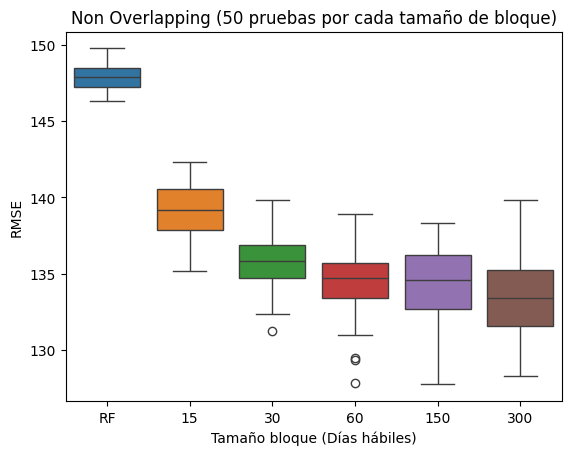

In [38]:
from matplotlib import pyplot as plt

all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Non Overlapping (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

In [39]:
# precisionMovingBlock = dict()
# for block_size in blockSizes:
#     precisionMovingBlock[block_size] = []
#     for k in range(10):
#         rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
#         print(f"RMSE: ({block_size}, {k})")
#         print(rmse0)
#         precisionMovingBlock[block_size].append(rmse0)
precisionMovingBlock = dict()
for block_size in blockSizes:
    precisionMovingBlock[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionMovingBlock[block_size].append(rmse0)

RMSE: (15, 0)
138.21015786223126
RMSE: (15, 1)
138.9793978681857
RMSE: (15, 2)
138.26255294674596
RMSE: (15, 3)
138.29217921208928
RMSE: (15, 4)
139.23468703704694
RMSE: (15, 5)
138.41234977966818
RMSE: (15, 6)
138.6940199397611
RMSE: (15, 7)
137.8314427377169
RMSE: (15, 8)
137.99378595235075
RMSE: (15, 9)
137.33589066655662
RMSE: (15, 10)
137.45303672012886
RMSE: (15, 11)
138.42819714933947
RMSE: (15, 12)
138.0866628571217
RMSE: (15, 13)
138.05302776345218
RMSE: (15, 14)
137.76095867497992
RMSE: (15, 15)
138.4277869690562
RMSE: (15, 16)
139.54496496186053
RMSE: (15, 17)
137.5477274919977
RMSE: (15, 18)
139.5368137995615
RMSE: (15, 19)
139.12227643826023
RMSE: (15, 20)
138.9346749511633
RMSE: (15, 21)
138.51661243284425
RMSE: (15, 22)
138.59447216841184
RMSE: (15, 23)
137.77318016961524
RMSE: (15, 24)
137.40363768991375
RMSE: (15, 25)
136.83301224940507
RMSE: (15, 26)
139.2567122944654
RMSE: (15, 27)
137.93953038054158
RMSE: (15, 28)
139.52725965966226
RMSE: (15, 29)
139.68183163835488

Text(0, 0.5, 'RMSE')

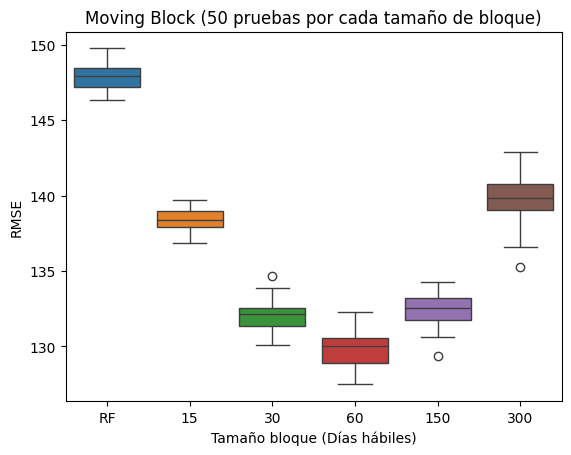

In [40]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Moving Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

In [41]:
# precisionCircularBlock = dict()
# for block_size in blockSizes:
#     precisionCircularBlock[block_size] = []
#     for k in range(10):
#         rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
#         print(f"RMSE: ({block_size}, {k})")
#         print(rmse0)
#         precisionCircularBlock[block_size].append(rmse0)
precisionCircularBlock = dict()
for block_size in blockSizes:
    precisionCircularBlock[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionCircularBlock[block_size].append(rmse0)

RMSE: (15, 0)
140.59132534459542
RMSE: (15, 1)
139.79658768181594
RMSE: (15, 2)
138.88628032843963
RMSE: (15, 3)
139.05746680769022
RMSE: (15, 4)
138.85292902105118
RMSE: (15, 5)
136.33282034685564
RMSE: (15, 6)
137.80427883293632
RMSE: (15, 7)
138.9930295272359
RMSE: (15, 8)
138.92661500540422
RMSE: (15, 9)
138.83812042271984
RMSE: (15, 10)
137.91144865268515
RMSE: (15, 11)
136.718120280101
RMSE: (15, 12)
138.98701118881857
RMSE: (15, 13)
138.22531495108086
RMSE: (15, 14)
136.84593977065316
RMSE: (15, 15)
136.06959770546115
RMSE: (15, 16)
139.22508115082996
RMSE: (15, 17)
138.19380526649763
RMSE: (15, 18)
138.8702150155828
RMSE: (15, 19)
140.66587511368766
RMSE: (15, 20)
137.30788277980608
RMSE: (15, 21)
140.6394710539237
RMSE: (15, 22)
137.9300919678175
RMSE: (15, 23)
138.31346616946863
RMSE: (15, 24)
138.84420803794927
RMSE: (15, 25)
138.7921852493652
RMSE: (15, 26)
140.21196547939064
RMSE: (15, 27)
138.0257735451768
RMSE: (15, 28)
138.82739653802403
RMSE: (15, 29)
135.3345658121121

Text(0, 0.5, 'RMSE')

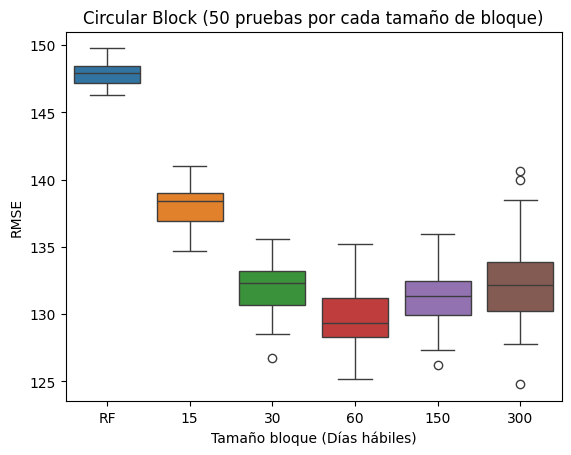

In [42]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Circular Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

Text(38.347222222222214, 0.5, 'RMSE')

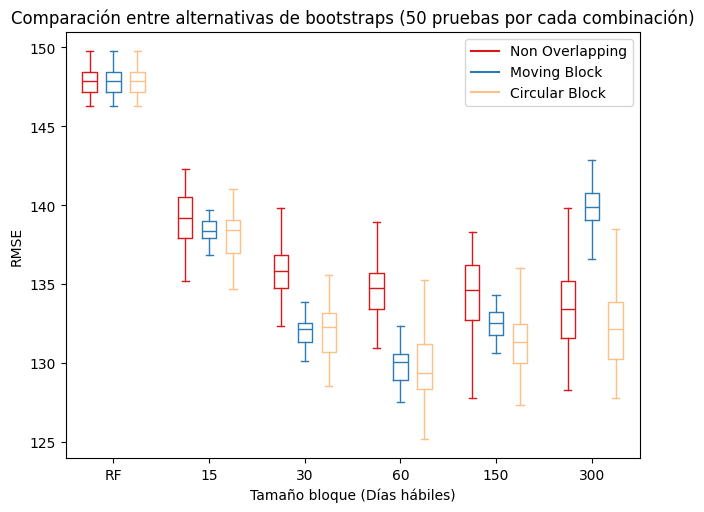

In [43]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")